In [1]:
from basketball_reference_web_scraper import client
from basketball_reference_web_scraper.data import Team
from basketball_reference_web_scraper.data import OutputType
import pandas as pd
import datetime as datetime
from datetime import datetime, timedelta
from dateutil.parser import parse
from pulp import *
import numpy as np
from sklearn import linear_model
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
import os.path
from os import path
import pytz
import seaborn as sns
from matplotlib import pyplot
from draft_kings.data import Sport
from draft_kings.client import contests
from draft_kings.client import available_players
from draft_kings.client import draft_group_details
from draft_kings.client import draftables

In [6]:
months_and_years = [(11, 2019), (12, 2019), (1, 2020), (2, 2020), (3, 2020), (7, 2020), (8, 2020)]

def scrape_bbref_data():
    for m, y in months_and_years:
        elif m == 8 and y == 2020: #for current month, scrape up to today's date
            for d in range(1, 3):
                file_name = "./AllCSVs/{0}_{1}_{2}_box_scores.csv".format(m, d, y)
                client.player_box_scores(day=d, month=m, year=y, output_type=OutputType.CSV, output_file_path=file_name)
        if m == 2:
            for d in range(1, 30):
                file_name = "./AllCSVs/{0}_{1}_{2}_box_scores.csv".format(m, d, y)
                client.player_box_scores(day=d, month=m, year=y, output_type=OutputType.CSV, output_file_path=file_name)
        elif m in [4, 11]:
            for d in range(1, 31):
                file_name = "./AllCSVs/{0}_{1}_{2}_box_scores.csv".format(m, d, y)
                client.player_box_scores(day=d, month=m, year=y, output_type=OutputType.CSV, output_file_path=file_name)
        else:
            for d in range(1, 32):
                file_name = "./AllCSVs/{0}_{1}_{2}_box_scores.csv".format(m, d, y)
                client.player_box_scores(day=d, month=m, year=y, output_type=OutputType.CSV, output_file_path=file_name)
scrape_bbref_data()

In [3]:
def load_bbref_data():
    all_tables = []
    for m, y in months_and_years:
        if m == 2:
            for d in range(1, 30):
                file_name = "./AllCSVs/{0}_{1}_{2}_box_scores.csv".format(m, d, y)
                table  = pd.read_csv(file_name)
                date = datetime(y, m, d)
                dates = [date] * len(table)
                table["Date"] = dates
                all_tables.append(table)

        elif m in [4, 11]:
            for d in range(1, 31):
                file_name = "./AllCSVs/{0}_{1}_{2}_box_scores.csv".format(m, d, y)
                table  = pd.read_csv(file_name)
                date = datetime(y, m, d)
                dates = [date] * len(table)
                table["Date"] = dates
                all_tables.append(table)
        
        else:
            for d in range(1, 32):
                file_name = "./AllCSVs/{0}_{1}_{2}_box_scores.csv".format(m, d, y)
                table  = pd.read_csv(file_name)
                date = datetime(y, m, d)
                dates = [date] * len(table)
                table["Date"] = dates
                all_tables.append(table)
    return all_tables
all_tables = load_bbref_data()

In [4]:
def write_bbref_data():
    full_df = all_tables[0]
    for i in range(1, len(all_tables)):
        current_table = all_tables[i]
        full_df = full_df.append(current_table)
    full_df.to_csv("./OutputCSVs/all_games.csv")

write_bbref_data()

In [5]:
df = pd.read_csv("./OutputCSVs/updated_team_stats.csv")
df["team"] = df["team"].str.upper()
all_games = pd.read_csv("./OutputCSVs/all_games.csv")

team_def = []
team_pace = []
team_tov = []
opp_def = []
opp_pace = []
opp_tov = []
all_games_teams = all_games[["team", "opponent"]]

for i in range(len(all_games_teams)):
    game = all_games_teams.loc[i]
    team = game["team"]
    opponent = game["opponent"]
    team_def.append(df[df["team"] == team]["drtg"].iloc[0])
    team_pace.append(df[df["team"] == team]["pace"].iloc[0])
    team_tov.append(df[df["team"] == team]["tov%"].iloc[0])
    opp_def.append(df[df["team"] == opponent]["drtg"].iloc[0])
    opp_pace.append(df[df["team"] == opponent]["pace"].iloc[0])
    opp_tov.append(df[df["team"] == opponent]["tov%"].iloc[0])
    
all_games["Team Defensive Rating"] = team_def
all_games["Team Pace"] = team_pace
all_games["Team Turnover %"] = team_tov
all_games["Opponent Defensive Rating"] = opp_def
all_games["Opponent Pace"] = opp_pace
all_games["Opponent Turnover %"] = opp_tov

all_games.to_csv("./OutputCSVs/all_games_new.csv")
df = pd.read_csv("./OutputCSVs/all_games_new.csv")
attempted_2s = df["attempted_field_goals"] - df["attempted_three_point_field_goals"]
made_2s = df["made_field_goals"] - df["made_three_point_field_goals"]
rebounds = df["offensive_rebounds"] + df["defensive_rebounds"]
at_home = df["location"] == "HOME"
df["attempted_two_point_field_goals"] = attempted_2s
df["made_two_point_field_goals"] = made_2s
df["total_rebounds"] = rebounds
df["at_home"] = at_home
df.to_csv("./OutputCSVs/all_games_updated.csv")
all_games_actual = pd.read_csv("./OutputCSVs/all_games_updated.csv")
all_games_actual =  all_games_actual.iloc[:, 3:].reset_index()

In [7]:
def get_stats(player, date, number_rows):
    converted_datetime = datetime.strptime(date, '%Y-%m-%d')
    player_rows = all_games_actual.loc[all_games_actual['name'] == player]
    #print(player_rows)
    selected_rows = []
    if (len(player_rows)) < number_rows:
        for i in range(len(player_rows)):
            selected_rows.append(player_rows.iloc[i])
        return pd.DataFrame(selected_rows)
    index = 0
    for i in range(len(player_rows)):
        curr_date = player_rows.iloc[i]['Date']
        if datetime.strptime(curr_date, '%Y-%m-%d') >= converted_datetime:
            index = i - 1
            break
    if index != 0:
        if index + 1 - number_rows < 0:
            for i in range(index + 1):
                selected_rows.append(player_rows.iloc[i])
        else:
            for i in range(index + 1 - number_rows, index + 1):
                selected_rows.append(player_rows.iloc[i])
#     elif converted_datetime >= players_rows[len(player_rows) - 1]:
    else:
        for i in range(len(player_rows) - number_rows, len(player_rows)):
            selected_rows.append(player_rows.iloc[i])
    return pd.DataFrame(selected_rows)

In [6]:
def get_points(row_data):
    if 'made_three_point_field_goals_y' in row_data.columns:
        three_pt_fgs = row_data['made_three_point_field_goals_y']
        two_pt_fgs = row_data['made_two_point_field_goals_y']
        made_fts = row_data['made_free_throws_y']
        total_rebounds = row_data['rebounds_y']
        assists = row_data['assists_y']
        blocks = row_data['blocks_y']
        steals = row_data['steals_y']
        turnovers = row_data['turnovers_y']
    else:
        three_pt_fgs = row_data['made_three_point_field_goals']
        two_pt_fgs = row_data['made_two_point_field_goals']
        made_fts = row_data['made_free_throws']
        total_rebounds = row_data['rebounds']
        assists = row_data['assists']
        blocks = row_data['blocks']
        steals = row_data['steals']
        turnovers = row_data['turnovers']
    FD_points = three_pt_fgs * 3 + two_pt_fgs * 2 + made_fts + total_rebounds * 1.2 + assists * 1.5 + blocks * 3 + steals * 3 - turnovers
    FD_dollars = FD_points * 200
    return (FD_points, FD_dollars)

def double_double(threes, twos, fts, rebounds, assists):
    points = float(threes) * 3 + float(twos) * 2 + float(fts)
    rebounds = rebounds.tolist()[0]
    assists = assists.tolist()[0]
    return (points >= 10 and rebounds >= 10) or (points >= 10 and assists >= 10) or (rebounds >= 10 and assists >= 10)

def triple_double(threes, twos, fts, rebounds, assists):
    points = float(threes) * 3 + float(twos) * 2 + float(fts)
    rebounds = rebounds.tolist()[0]
    assists = assists.tolist()[0]
    return points >= 10 and rebounds >= 10 and assists >= 10

def get_draftkings_points(row_data):
    if 'made_three_point_field_goals_y' in row_data.columns:
        three_pt_fgs = float(row_data['made_three_point_field_goals_y'])
        two_pt_fgs = float(row_data['made_two_point_field_goals_y'])
        made_fts = float(row_data['made_free_throws_y'])
        total_rebounds = float(row_data['rebounds_y'])
        assists = float(row_data['assists_y'])
        blocks = row_data['blocks_y']
        steals = row_data['steals_y']
        turnovers = row_data['turnovers_y']
    else:
        three_pt_fgs = float(row_data['made_three_point_field_goals'])
        two_pt_fgs = float(row_data['made_two_point_field_goals'])
        made_fts = float(row_data['made_free_throws'])
        total_rebounds = row_data['rebounds']
        assists = row_data['assists']
        blocks = row_data['blocks']
        steals = row_data['steals']
        turnovers = row_data['turnovers']
    DK_points = three_pt_fgs * 3.5 + two_pt_fgs * 2 + made_fts + total_rebounds * 1.25 + assists * 1.5 + blocks * 2 + steals * 2 - .5 * turnovers + 1.5 * double_double(three_pt_fgs, two_pt_fgs, made_fts, rebounds, assists) + 3 * triple_double(three_pt_fgs, two_pt_fgs, made_fts, rebounds, assists)
    DK_dollars = DK_points * 187.5
    return (DK_points, DK_dollars)

In [8]:
def weight_function(statistic, weight):
    s = 0
    if type(statistic) == np.ndarray:
        for i in range(len(statistic)):
            s += statistic[len(statistic) - i - 1] * (weight ** i)
    else:
        for i in range(len(statistic)):
            s += statistic.iloc[len(statistic) - i - 1,] * (weight ** i)
    return s

In [9]:
def time_weighted_average(rows, statistic, weight):
    if rows.empty:
        return 0
    stat = rows[statistic]
    this_num = 1 / weight_function(np.ones(len(stat)), weight)
    return this_num * weight_function(stat, weight)
player_box_scores = pd.read_csv('./OutputCSVs/all_games_updated.csv')

In [10]:
def statline_predictor(player_box_scores, input_statistics, sample_size = 5, weight = .8):
    player_box_scores = player_box_scores[~player_box_scores.index.duplicated()]
    player_box_scores.reindex(range(len(player_box_scores)), axis = "index")
    predicted_statlines = pd.DataFrame(index = player_box_scores.index, columns = input_statistics).fillna(0).T
    index_len = len(player_box_scores.index)
    for box_index in player_box_scores.index:
        box_score = player_box_scores.loc[box_index]
        player_name = box_score["name"]
        game_date = str(box_score["Date"])[:10]
        last_n_rows = get_stats(player_name, game_date, sample_size)
        weighted_stats = [player_name, box_score["team"], game_date, box_score["location"], box_score["opponent"]]
        for stat in input_statistics[5:]:
            weighted_stats.append(round(time_weighted_average(last_n_rows, stat, weight), 2))
        predicted_statlines[box_index] = weighted_stats
    return predicted_statlines.T

In [11]:
def minutes_predictor(weighted_stats):
    if "seconds_played_y" in weighted_stats.index:
        return np.mean(weighted_stats["seconds_played_y"])/60
    else:
        return np.mean(weighted_stats["seconds_played"])/60
def recent_average(weighted_stats):
    if len(weighted_stats.index) == 0:
        return 0
    if "made_three_point_field_goals_y" in weighted_stats.index:
        return 3*np.mean(weighted_stats["made_three_point_field_goals_y"]) + 2*np.mean(weighted_stats["made_two_point_field_goals_y"]) + np.mean(weighted_stats["made_free_throws_y"]) + 1.2*(np.mean(weighted_stats["offensive_rebounds_y"]) + np.mean(weighted_stats["defensive_rebounds_y"])) + 1.5*np.mean(weighted_stats["assists_y"]) + 3*np.mean(weighted_stats["blocks_y"]) + 3*np.mean(weighted_stats["steals_y"]) - np.mean(weighted_stats["turnovers_y"])
    else:
        return 3*np.mean(weighted_stats["made_three_point_field_goals"]) + 2*np.mean(weighted_stats["made_two_point_field_goals"]) + np.mean(weighted_stats["made_free_throws"]) + 1.2*(np.mean(weighted_stats["offensive_rebounds"]) + np.mean(weighted_stats["defensive_rebounds"])) + 1.5*np.mean(weighted_stats["assists"]) + 3*np.mean(weighted_stats["blocks"]) + 3*np.mean(weighted_stats["steals"]) - np.mean(weighted_stats["turnovers"])

In [12]:
all_abbrv = {'ATLANTA HAWKS':'Atlanta', 'BOSTON CELTICS':'Boston', 'BROOKLYN NETS':'Brooklyn', 'CHARLOTTE HORNETS':'Charlotte', 'CHICAGO BULLS':'Chicago', 'CLEVELAND CAVALIERS':'Cleveland', 'DALLAS MAVERICKS':'Dallas',
            'DENVER NUGGETS':'Denver', 'DETROIT PISTONS':'Detroit', 'GOLDEN STATE WARRIORS':'Golden State', 'HOUSTON ROCKETS':'Houston', 'INDIANA PACERS':'Indiana', 'LOS ANGELES CLIPPERS':'LA Clippers', 'LOS ANGELES LAKERS':'LA Lakers',
            'MEMPHIS GRIZZLIES':'Memphis', 'MIAMI HEAT':'Miami', 'MILWAUKEE BUCKS':'Milwaukee', 'MINNESOTA TIMBERWOLVES':'Minnesota', 'NEW ORLEANS PELICANS':'New Orleans', 'NEW YORK KNICKS':'New York', 'OKLAHOMA CITY THUNDER':'Oklahoma City', 'ORLANDO MAGIC':'Orlando',
            'PHILADELPHIA 76ERS':'Philadelphia', 'PHOENIX SUNS':'Phoenix', 'PORTLAND TRAIL BLAZERS':'Portland', 'SACRAMENTO KINGS':'Sacramento', 'SAN ANTONIO SPURS':'San Antonio', 'TORONTO RAPTORS':'Toronto', 'UTAH JAZZ':'Utah', 'WASHINGTON WIZARDS':'Washington'}
positions = pd.read_csv('./OutputCSVs/all_player_positions.csv')
dbp = pd.read_csv('./OutputCSVs/team_def_vs_position.csv')
main_df = pd.read_csv('./AllCSVs/predictions_for_07_31_2020_unplayed.csv')

def process_dual_positions(position1, position2, team, opponent):
    first_team_subrank =  dbp.loc[dbp['Team']==team, 'vs {0}'.format(position1)].iloc[0]
    second_team_subrank =  dbp.loc[dbp['Team']==team, 'vs {0}'.format(position2)].iloc[0]
    first_opp_subrank =  dbp.loc[dbp['Team']==opponent, 'vs {0}'.format(position1)].iloc[0]
    second_opp_subrank =  dbp.loc[dbp['Team']==opponent, 'vs {0}'.format(position2)].iloc[0]
    return first_team_subrank, second_team_subrank, first_opp_subrank, second_opp_subrank
    
def add_team_defense(main_df):
    team_def_vs_pos = []
    opp_def_vs_pos = []

    player_positions = pd.Series(positions['position'].values,index=positions['player name']).to_dict()

    for i in range(len(main_df)):
        name = main_df['name'][i]
        position = player_positions.get(name)
        team = all_abbrv.get(main_df['team'][i])
        opponent = all_abbrv.get(main_df['opponent'][i])
        if position is None:
            team_def_vs_pos.append('')
            opp_def_vs_pos.append('')
        else:
            if position in ['PG','SG','SF','PF','C']:
                team_def_vs_pos.append(dbp.loc[dbp['Team']==team, 'vs {0}'.format(position)].iloc[0])
                opp_def_vs_pos.append(dbp.loc[dbp['Team']==opponent, 'vs {0}'.format(position)].iloc[0])
            elif position == 'G':
                pdp = process_dual_positions('PG', 'SG', team, opponent)
                team_def_vs_pos.append((pdp[0] + pdp[1])/2)
                opp_def_vs_pos.append((pdp[2] + pdp[3])/2)
            elif position == 'F':
                pdp = process_dual_positions('SF', 'PF', team, opponent)
                team_def_vs_pos.append((pdp[0] + pdp[1])/2)
                opp_def_vs_pos.append((pdp[2] + pdp[3])/2)
            elif position in ['G-F','F-G']:
                pdp = process_dual_positions('SG', 'SF', team, opponent)
                team_def_vs_pos.append((pdp[0] + pdp[1])/2)
                opp_def_vs_pos.append((pdp[2] + pdp[3])/2)
            elif position in ['F-C']:
                pdp = process_dual_positions('PF', 'C', team, opponent)
                team_def_vs_pos.append((pdp[0] + pdp[1])/2)
                opp_def_vs_pos.append((pdp[2] + pdp[3])/2)
    #main_df['team def vs pos'] = team_def_vs_pos
    main_df['Opponent Defensive Rank vs Position'] = opp_def_vs_pos
    return main_df
#add_team_defense(pd.read_csv('./AllCSVs/predictions_for_07_31_2020_unplayed.csv'))

In [50]:
input_statistics = ["name", "team", "date", "location", "opponent", "made_field_goals", "made_two_point_field_goals", "attempted_two_point_field_goals", "attempted_field_goals", "made_three_point_field_goals", "attempted_three_point_field_goals", "attempted_free_throws", "made_free_throws", "offensive_rebounds", "defensive_rebounds", "assists", "blocks", "turnovers", "steals", "seconds_played", "Opponent Defensive Rating", "Opponent Turnover %", 'Team Defensive Rating', 'Team Pace', 'Team Turnover %', 'Opponent Pace']
output_statistics = ["name", "team", "date", "location", "opponent", "minutes", "made_two_point_field_goals", "made_three_point_field_goals", "made_free_throws", "rebounds", "assists", "blocks", "steals", "turnovers", "recent_average", "10_game_average", "3_game_average", "10_3_ratio", "10_3_difference", "hot", "cold", "fantasy_points"]

def statline_output(player_box_scores, input_statistics):
    weighted_lines_7_9 = statline_predictor(player_box_scores, input_statistics, 7, .9)
    weighted_lines_8_8 = statline_predictor(player_box_scores, input_statistics, 8, .8)
    weighted_lines_8_85 = statline_predictor(player_box_scores, input_statistics, 8, .85)
    weighted_lines_8_9 = statline_predictor(player_box_scores, input_statistics, 8, .9)
    weighted_lines_to_keep_7_9 = weighted_lines_7_9[weighted_lines_7_9.seconds_played > 1000]
    weighted_lines_to_keep_8_8 = weighted_lines_8_8[weighted_lines_8_8.seconds_played > 1000]
    weighted_lines_to_keep_8_85 = weighted_lines_8_85[weighted_lines_8_85.seconds_played > 1000]
    weighted_lines_to_keep_8_9 = weighted_lines_8_9[weighted_lines_8_9.seconds_played > 1000]
    df_to_keep = player_box_scores[weighted_lines_8_9.seconds_played > 1000]
    df_to_keep["attempted_two_point_field_goals"] = df_to_keep["attempted_field_goals"] - df_to_keep["attempted_three_point_field_goals"]
    df_to_keep["made_two_point_field_goals"] = df_to_keep["made_field_goals"] - df_to_keep["made_three_point_field_goals"]
    weighted_lines_to_keep_7_9['name_date'] = weighted_lines_to_keep_7_9["name"] + weighted_lines_to_keep_7_9["date"].astype(str)
    weighted_lines_to_keep_8_8['name_date'] = weighted_lines_to_keep_8_8["name"] + weighted_lines_to_keep_8_8["date"].astype(str)
    weighted_lines_to_keep_8_85['name_date'] = weighted_lines_to_keep_8_85["name"] + weighted_lines_to_keep_8_85["date"].astype(str)
    weighted_lines_to_keep_8_9['name_date'] = weighted_lines_to_keep_8_9["name"] + weighted_lines_to_keep_8_9["date"].astype(str)
    df_to_keep['name_date'] = df_to_keep["name"] + df_to_keep["Date"].astype(str)
    df_merged_7_9 = weighted_lines_to_keep_7_9.merge(df_to_keep, left_on = 'name_date', right_on = 'name_date')
    df_merged_7_9["rebounds_y"] = df_merged_7_9["offensive_rebounds_y"] + df_merged_7_9["defensive_rebounds_y"]
    df_merged_7_9["location_x"] = df_merged_7_9["location_x"] == "HOME"
    df_merged_7_9["location_y"] = df_merged_7_9["location_y"] == "HOME"
    df_merged_8_8 = weighted_lines_to_keep_8_8.merge(df_to_keep, left_on = 'name_date', right_on = 'name_date')
    df_merged_8_8["rebounds_y"] = df_merged_8_8["offensive_rebounds_y"] + df_merged_8_8["defensive_rebounds_y"]
    df_merged_8_8["location_x"] = df_merged_8_8["location_x"] == "HOME"
    df_merged_8_8["location_y"] = df_merged_8_8["location_y"] == "HOME"
    df_merged_8_85 = weighted_lines_to_keep_8_85.merge(df_to_keep, left_on = 'name_date', right_on = 'name_date')
    df_merged_8_85["rebounds_y"] = df_merged_8_85["offensive_rebounds_y"] + df_merged_8_85["defensive_rebounds_y"]
    df_merged_8_85["location_x"] = df_merged_8_85["location_x"] == "HOME"
    df_merged_8_85["location_y"] = df_merged_8_85["location_y"] == "HOME"
    df_merged_8_9 = weighted_lines_to_keep_8_9.merge(df_to_keep, left_on = 'name_date', right_on = 'name_date')
    df_merged_8_9["rebounds_y"] = df_merged_8_9["offensive_rebounds_y"] + df_merged_8_9["defensive_rebounds_y"]
    df_merged_8_9["location_x"] = df_merged_8_9["location_x"] == "HOME"
    df_merged_8_9["location_y"] = df_merged_8_9["location_y"] == "HOME"
    predictors_7_9 = df_merged_7_9.iloc[:,[3, 7, 6, 9, 10, 12, 11, 13, 14, 15, 18, 16, 17, 22, 23, 24, 20, 25, 21]]
    predictors_8_8 = df_merged_8_8.iloc[:,[3, 7, 6, 9, 10, 12, 11, 13, 14, 15, 18, 16, 17, 22, 23, 24, 20, 25, 21]]
    predictors_8_85 = df_merged_8_85.iloc[:,[3, 7, 6, 9, 10, 12, 11, 13, 14, 15, 18, 16, 17, 22, 23, 24, 20, 25, 21]]
    predictors_8_9 = df_merged_8_9.iloc[:,[3, 7, 6, 9, 10, 12, 11, 13, 14, 15, 18, 16, 17, 22, 23, 24, 20, 25, 21]]
    df_merged_7_9["fantasy_points"] = [float(get_points(df_merged_7_9[df_merged_7_9["name_date"] == player_name])[0]) for player_name in df_merged_7_9["name_date"]]
    df_merged_8_8["fantasy_points"] = [float(get_points(df_merged_8_8[df_merged_8_8["name_date"] == player_name])[0]) for player_name in df_merged_8_8["name_date"]]
    df_merged_8_85["fantasy_points"] = [float(get_points(df_merged_8_85[df_merged_8_85["name_date"] == player_name])[0]) for player_name in df_merged_8_85["name_date"]]
    df_merged_8_9["fantasy_points"] = [float(get_points(df_merged_8_9[df_merged_8_9["name_date"] == player_name])[0]) for player_name in df_merged_8_9["name_date"]]
    fantasy_points_8_9 = df_merged_8_9.iloc[:,58]
    freethrows = df_merged_7_9.iloc[:,38]
    twopoints = df_merged_8_8.iloc[:,56]
    threepoints = df_merged_8_85.iloc[:,36]
    blocks = df_merged_8_85.iloc[:,44]
    assists = df_merged_8_9.iloc[:,42]
    rebounds = df_merged_8_9.iloc[:,57]
    turnovers = df_merged_8_9.iloc[:,45]
    seconds = df_merged_8_9.iloc[:,33]
    steals = df_merged_8_9.iloc[:,43]
    fantasy_model_8_9 = RidgeCV().fit(predictors_8_9, fantasy_points_8_9)
    freethrow_model = RidgeCV().fit(predictors_7_9, freethrows)
    twopoint_model = RidgeCV().fit(predictors_8_8, twopoints)
    threepoint_model = RidgeCV().fit(predictors_8_85, threepoints)
    block_model = RidgeCV().fit(predictors_8_85, blocks)
    assist_model = RidgeCV().fit(predictors_8_9, assists)
    rebound_model = RidgeCV().fit(predictors_8_9, rebounds)
    turnover_model = RidgeCV().fit(predictors_8_9, turnovers)
    second_model = GradientBoostingRegressor().fit(predictors_8_9, seconds)
    steal_model = RidgeCV().fit(predictors_8_9, steals)

    
    output_statlines = pd.DataFrame(index = weighted_lines_8_9.index, columns = output_statistics).fillna(0)
    output_statlines["name"] = weighted_lines_8_9["name"]
    output_statlines["team"] = weighted_lines_8_9["team"]
    output_statlines["date"] = weighted_lines_8_9["date"]
    output_statlines["location"] = weighted_lines_8_9["location"]
    output_statlines["opponent"] = weighted_lines_8_9["opponent"]
    weighted_lines_7_9["location"] = weighted_lines_7_9["location"] == "HOME"
    weighted_lines_8_8["location"] = weighted_lines_8_8["location"] == "HOME"
    weighted_lines_8_85["location"] = weighted_lines_8_85["location"] == "HOME"
    weighted_lines_8_9["location"] = weighted_lines_8_9["location"] == "HOME"
    weighted_lines_7_9 = weighted_lines_7_9.iloc[:, [3, 7, 6, 9, 10, 12, 11, 13, 14, 15, 18, 16, 17, 22, 23, 24, 20, 25, 21]]
    weighted_lines_8_8 = weighted_lines_8_8.iloc[:, [3, 7, 6, 9, 10, 12, 11, 13, 14, 15, 18, 16, 17, 22, 23, 24, 20, 25, 21]]
    weighted_lines_8_85 = weighted_lines_8_85.iloc[:, [3, 7, 6, 9, 10, 12, 11, 13, 14, 15, 18, 16, 17, 22, 23, 24, 20, 25, 21]]
    weighted_lines_8_9 = weighted_lines_8_9.iloc[:, [3, 7, 6, 9, 10, 12, 11, 13, 14, 15, 18, 16, 17, 22, 23, 24, 20, 25, 21]]

    output_statlines["minutes"] = second_model.predict(weighted_lines_8_9) / 60
    output_statlines["made_two_point_field_goals"] = twopoint_model.predict(weighted_lines_8_8)
    output_statlines["made_three_point_field_goals"] = threepoint_model.predict(weighted_lines_8_85) 
    output_statlines["made_free_throws"] = freethrow_model.predict(weighted_lines_7_9)
    output_statlines["rebounds"] = rebound_model.predict(weighted_lines_8_9)
    output_statlines["assists"] = assist_model.predict(weighted_lines_8_9)
    output_statlines["blocks"] = block_model.predict(weighted_lines_8_85)
    output_statlines["steals"] = steal_model.predict(weighted_lines_8_9) 
    output_statlines["turnovers"] = turnover_model.predict(weighted_lines_8_9)
    output_statlines["fantasy_points_8_9"] = fantasy_model_8_9.predict(weighted_lines_8_9)
    for box_index in output_statlines.index:
        if output_statlines.loc[box_index, "fantasy_points_8_9"] < -100:
            output_statlines.loc[box_index, "minutes"] = 4
        pred_minutes = max(0, output_statlines.loc[box_index, "minutes"])
        if pred_minutes <= 19:
            output_statlines.loc[box_index, "made_two_point_field_goals"] = output_statlines.loc[box_index, "made_two_point_field_goals"] * pred_minutes/19
            output_statlines.loc[box_index, "made_three_point_field_goals"] = output_statlines.loc[box_index, "made_three_point_field_goals"] * pred_minutes/19
            output_statlines.loc[box_index, "made_free_throws"] = output_statlines.loc[box_index, "made_free_throws"] * pred_minutes/19
            output_statlines.loc[box_index, "rebounds"] = output_statlines.loc[box_index, "rebounds"] * pred_minutes/19
            output_statlines.loc[box_index, "assists"] = output_statlines.loc[box_index, "assists"] * pred_minutes/19
            output_statlines.loc[box_index, "blocks"] = output_statlines.loc[box_index, "blocks"] * pred_minutes/19
            output_statlines.loc[box_index, "steals"] = output_statlines.loc[box_index, "steals"] * pred_minutes/19
            output_statlines.loc[box_index, "turnovers"] = output_statlines.loc[box_index, "turnovers"] * pred_minutes/19
        output_statlines.loc[box_index, "minutes"] = round(pred_minutes, 2)
        output_statlines.loc[box_index, "made_two_point_field_goals"] = round(max(0, output_statlines.loc[box_index, "made_two_point_field_goals"]), 2)
        output_statlines.loc[box_index, "made_three_point_field_goals"] = round(max(0, output_statlines.loc[box_index, "made_three_point_field_goals"]), 2)
        output_statlines.loc[box_index, "made_free_throws"] = round(max(0, output_statlines.loc[box_index, "made_free_throws"]), 2)
        output_statlines.loc[box_index, "rebounds"] = round(max(0, output_statlines.loc[box_index, "rebounds"]), 2)
        output_statlines.loc[box_index, "assists"] = round(max(0, output_statlines.loc[box_index, "assists"]), 2)
        output_statlines.loc[box_index, "blocks"] = round(max(0, output_statlines.loc[box_index, "blocks"]), 2)
        output_statlines.loc[box_index, "steals"] = round(max(0, output_statlines.loc[box_index, "steals"]), 2)
        output_statlines.loc[box_index, "turnovers"] = round(max(0, output_statlines.loc[box_index, "turnovers"]), 2)
        output_statlines.loc[box_index, "recent_average"] = round(np.mean([recent_average(weighted_lines_8_85.loc[box_index]), recent_average(weighted_lines_8_9.loc[box_index]), recent_average(weighted_lines_8_8.loc[box_index]), recent_average(weighted_lines_7_9.loc[box_index])]), 2)
        last_10_games = get_stats(output_statlines.loc[box_index, "name"], output_statlines.loc[box_index, "date"], 10)
        last_3_games = get_stats(output_statlines.loc[box_index, "name"], output_statlines.loc[box_index, "date"], 3)
        output_statlines.loc[box_index, "10_game_average"] = round(recent_average(last_10_games), 2)
        output_statlines.loc[box_index, "3_game_average"] = round(recent_average(last_3_games), 2)
        output_statlines.loc[box_index, "10_3_ratio"] = (output_statlines.loc[box_index, "10_game_average"] + 1)/(output_statlines.loc[box_index, "3_game_average"] + 1)
        output_statlines.loc[box_index, "10_3_difference"] = output_statlines.loc[box_index, "10_game_average"] - output_statlines.loc[box_index, "3_game_average"]
        output_statlines.loc[box_index, "hot"] = np.log(((-7 * min(0, output_statlines.loc[box_index, "10_3_ratio"] - .83)) * (-1 * min(0, output_statlines.loc[box_index, "10_3_difference"] + 6))) + 1)
        output_statlines.loc[box_index, "cold"] = np.log(((7 * max(0, output_statlines.loc[box_index, "10_3_ratio"] - 1.22)) * (max(0, output_statlines.loc[box_index, "10_3_difference"] - 6.5))) + 1)
    
    output_statlines = add_team_defense(output_statlines)
    return output_statlines

In [14]:
def generate_optimal_lineup(players, positions, values, costs, budget):
    num_variables = len(players)
    
    lp = LpProblem("My LP Problem", pulp.LpMaximize)
    
    d = {}
    for i in range(0, num_variables):
        d[players[i]] = LpVariable(players[i], cat="Binary")
    
    objective = sum(np.array(values) * np.array(list(d.values())))
    lp += objective
    
    pg_constraint = 0
    sg_constraint = 0
    sf_constraint = 0
    pf_constraint = 0
    c_constraint = 0
    for i in range(0, len(positions)):
        if positions[i] == "PG":
            pg_constraint += d[players[i]]
        elif positions[i] == "SG":
            sg_constraint += d[players[i]]
        elif positions[i] == "SF":
            sf_constraint += d[players[i]]
        elif positions[i] == "PF":
            pf_constraint += d[players[i]]
        else:
            c_constraint += d[players[i]]
    lp += pg_constraint == 2
    lp += sg_constraint == 2
    lp += sf_constraint == 2
    lp += pf_constraint == 2
    lp += c_constraint == 1
    
    cost = sum(np.array(costs) * np.array(list(d.values())))
    lp += cost <= budget
    
    lp.solve()
    
    lineup = [variable.name for variable in lp.variables() if variable.varValue == 1]
    return lineup

def generate_optimal_lineup_draftkings(players, positions, values, costs, budget):
    num_variables = len(players)
    
    lp = LpProblem("My LP Problem", pulp.LpMaximize)
    
    d = {}
    for i in range(0, num_variables):
        d[players[i]] = LpVariable(players[i], cat="Binary")
    
    objective = sum(np.array(values) * np.array(list(d.values())))
    lp += objective
    
    pg_constraint = 0
    sg_constraint = 0
    sf_constraint = 0
    pf_constraint = 0
    c_constraint = 0
    g_constraint = 0
    f_constraint = 0
    player_constraint = 0
    for i in range(0, len(positions)):
        if "PG" in positions[i] or "SG" in positions[i]:
            if "PG" in positions[i]:
                pg_constraint += d[players[i]]
            if "SG" in positions[i]:
                sg_constraint += d[players[i]]
            g_constraint += d[players[i]]
        if "PF" in positions[i] or "SF" in positions[i]:
            if "PF" in positions[i]:
                pf_constraint += d[players[i]]
            if "SF" in positions[i]:
                sf_constraint += d[players[i]]
            f_constraint += d[players[i]]
        if "C" in positions[i]:
            c_constraint += d[players[i]]
        player_constraint += d[players[i]]
    lp += pg_constraint <= 3
    lp += sg_constraint <= 3
    lp += sf_constraint <= 3
    lp += pf_constraint <= 3
    lp += pg_constraint >= 1
    lp += sg_constraint >= 1
    lp += sf_constraint >= 1
    lp += pf_constraint >= 1
    lp += c_constraint >= 1
    lp += g_constraint <= 4
    lp += f_constraint <= 4
    lp += g_constraint >= 3
    lp += f_constraint >= 3
    lp += c_constraint <= 2
    lp += player_constraint == 8
    
    cost = sum(np.array(costs) * np.array(list(d.values())))
    lp += cost <= budget
    
    lp.solve()
    
    lineup = [variable.name for variable in lp.variables() if variable.varValue == 1]
    return lineup

In [15]:
def box_scores_for_range_of_days(start_date, end_date):
    all_tables = []
    start_month = start_date.month
    end_month = end_date.month
    start_year = start_date.year
    end_year = end_date.year
    
    for y in range(start_year, end_year + 1):
        sm, em = 1, 12
        if y == start_year:
            sm = start_month
        if y == end_year:
            em = end_month
        for m in range(sm, em + 1):
            if m == start_month and y == start_year:
                start_day = start_date.day
            else:
                start_day = 1
            if m == end_month and y == end_year:
                end_day = end_date.day
            else:
                if m == 2:
                    end_day = 29
                elif m in [9, 4, 6, 11]:
                    end_day = 30
                else:
                    end_day = 31
        
            for d in range(start_day, end_day + 1):
                file_name = "./AllCSVs/{0}_{1}_{2}_box_scores.csv".format(m, d, y)
                if not path.exists(file_name):
                    continue
                if pd.read_csv(file_name).empty:
                    client.player_box_scores(day=d, month=m, year=y, output_type=OutputType.CSV, output_file_path=file_name)
                table = pd.read_csv(file_name)
                date = datetime(y, m, d)
                dates = [date] * len(table)
                table["Date"] = dates
                all_tables.append(table)

    full_df = all_tables[0]
    for i in range(1, len(all_tables)):
        current_table = all_tables[i]
        full_df = full_df.append(current_table)
    
    full_df.index = range(full_df.shape[0])
    df = pd.read_csv("./OutputCSVs/updated_team_stats.csv")
    df["team"] = df["team"].str.upper()

    team_def = []
    team_pace = []
    team_tov = []
    opp_def = []
    opp_pace = []
    opp_tov = []
    all_games_teams = full_df[["team", "opponent"]]

    for i in range(len(all_games_teams)):
        game = all_games_teams.loc[i]
        team = game["team"].upper()
        opponent = game["opponent"].upper()
        team_def.append(df[df["team"] == team]["drtg"].iloc[0])
        team_pace.append(df[df["team"] == team]["pace"].iloc[0])
        team_tov.append(df[df["team"] == team]["tov%"].iloc[0])
        opp_def.append(df[df["team"] == opponent]["drtg"].iloc[0])
        opp_pace.append(df[df["team"] == opponent]["pace"].iloc[0])
        opp_tov.append(df[df["team"] == opponent]["tov%"].iloc[0])
    
    full_df["Team Defensive Rating"] = team_def
    full_df["Team Pace"] = team_pace
    full_df["Team Turnover %"] = team_tov
    full_df["Opponent Defensive Rating"] = opp_def
    full_df["Opponent Pace"] = opp_pace
    full_df["Opponent Turnover %"] = opp_tov
    return full_df

In [16]:
def make_predictions(start_date, end_date, output = True):
    input_statistics = ["name", "team", "date", "location", "opponent", "made_field_goals", "made_two_point_field_goals", "attempted_two_point_field_goals", "attempted_field_goals", "made_three_point_field_goals", "attempted_three_point_field_goals", "attempted_free_throws", "made_free_throws", "offensive_rebounds", "defensive_rebounds", "assists", "blocks", "turnovers", "steals", "seconds_played", "Opponent Defensive Rating", "Opponent Turnover %", 'Team Defensive Rating', 'Team Pace', 'Team Turnover %', 'Opponent Pace']
    full_df = box_scores_for_range_of_days(start_date, end_date)
    predicted_statlines = statline_output(full_df, input_statistics)
    if output:
        output_filename = './AllCSVs/' + str(start_date.month) + '_' + str(start_date.day) + '_' + str(end_date.month) + '_' + str(end_date.day) + '_' + str(end_date.year) + '_predicted_box_scores.csv'
        predicted_statlines.to_csv(output_filename)
    return predicted_statlines

In [17]:
def predict_next_day(start_date, game_date):
    season_schedule = client.season_schedule(season_end_year = game_date.year)
    schedule_on_date = [game for game in season_schedule if (game['start_time'] - timedelta(hours = 4)).day == game_date.day and game['start_time'].month == game_date.month]
    team_objs_on_date = [game["home_team"] for game in schedule_on_date] + [game["away_team"] for game in schedule_on_date]
    teams_on_date = [t.name.replace("_", " ") for t in team_objs_on_date]
    predictions_for_date = make_predictions(start_date, game_date, output = False)
    players_on_date = predictions_for_date[predictions_for_date.team.isin(teams_on_date)]
    mstr, dstr = str(game_date.month), str(game_date.day)
    if game_date.month < 10:
        mstr = "0" + mstr
    if game_date.day < 10:
        dstr = "0" + dstr
    tstr = mstr + "-" + dstr
    statlines_on_date = players_on_date[players_on_date.date.str.contains(tstr)]
    statlines_on_date.index = range(statlines_on_date.shape[0])
    output_filename = './AllCSVs/predictions_for_' + mstr + "_" + dstr + '_from_' + str(start_date.month) + '_' + str(start_date.day) + '_' + str(start_date.year) + '.csv'
    statlines_on_date.to_csv(output_filename)
    return statlines_on_date
#feb_28_predictions = predict_next_day(datetime(2020, 1, 27), datetime(2020, 2, 28))

In [18]:
def append_actual_results(start_date, game_date):
    predicted_results = predict_next_day(start_date, game_date)
    actual_results = box_scores_for_range_of_days(game_date, game_date)
    actual_results["made_two_point_field_goals"] = actual_results["made_field_goals"] - actual_results["made_three_point_field_goals"]
    actual_results["rebounds"] = actual_results["offensive_rebounds"] + actual_results["defensive_rebounds"]
    pred_outputs = [float(get_points(predicted_results[predicted_results["name"] == player_name])[0]) for player_name in predicted_results["name"]]
    actual_outputs = [float(get_points(actual_results[actual_results["name"] == player_name])[0]) for player_name in predicted_results["name"]]
    predicted_results["predicted_points"] = pred_outputs
    predicted_results["actual_points"] = actual_outputs
    output_filename = './AllCSVs/' + str(game_date.month) + '_' + str(game_date.day) + '_' + str(game_date.year) + '_box_scores_predicted_with_actual.csv'
    predicted_results.to_csv(output_filename)
    return predicted_results

#append_actual_results(datetime(2020, 2, 1), datetime(2020, 2, 12))

In [19]:
def alternate_contests(start_date, game_date, search_datetime, inclusive):
    season_schedule = client.season_schedule(season_end_year = game_date.year)
    schedule_on_date = [game for game in season_schedule if (game['start_time'] - timedelta(hours = 4)).day == game_date.day and (game['start_time'] - timedelta(hours = 4)).month == game_date.month]
    times_on_date = np.unique([game['start_time'] - timedelta(hours = 4) for game in schedule_on_date])
    print(times_on_date)
    if not inclusive:
        game_teams = [game["home_team"] for game in schedule_on_date if (game['start_time'] - timedelta(hours = 4)) == search_datetime] + [game["away_team"] for game in schedule_on_date if (game['start_time'] - timedelta(hours = 4)) == search_datetime]
    else:
        times_after_search = [t for t in times_on_date if 60 * t.hour + t.minute >= 60 * search_datetime.hour + search_datetime.minute]
        game_teams = [game["home_team"] for game in schedule_on_date if (game['start_time'] - timedelta(hours = 4)) in times_after_search] + [game["away_team"] for game in schedule_on_date if (game['start_time'] - timedelta(hours = 4)) in times_after_search]
    game_team_strings = [str(team)[5:].replace("_", " ") for team in game_teams]
    predictions_for_date = predict_next_day(start_date, game_date)
    players_on_date = predictions_for_date[predictions_for_date.team.isin(game_team_strings)]
    output_filename = './AllCSVs/' + str(game_date.month) + '_' + str(game_date.day) + '_' + str(game_date.year) + '_alternate_' + str(search_datetime.hour) + "_" + str(search_datetime.minute) + '.csv'
    players_on_date.to_csv(output_filename)
    return players_on_date
#alternate_contests(datetime(2020, 1, 1), datetime(2020, 1, 13), datetime(2020, 1, 13, 21, 30), True)

In [51]:
def matchup_lookup(matchups, team):
    matchup = [m for m in matchups if team in m][0]
    if team == matchup[0]:
        return matchup[1]
    else:
        return matchup[0]

def predict_unplayed_games(start_date, game_date):
    season_schedule = client.season_schedule(season_end_year = game_date.year)
    schedule_on_date = [game for game in season_schedule if (game['start_time'] - timedelta(hours = 4)).day == game_date.day and (game['start_time'] - timedelta(hours = 4)).month == game_date.month]
    available_box_scores = box_scores_for_range_of_days(start_date, game_date)
    game_teams = [game["home_team"] for game in schedule_on_date] + [game["away_team"] for game in schedule_on_date]
    matchups = [[str(game["home_team"])[5:].replace("_", " "), str(game["away_team"])[5:].replace("_", " ")] for game in schedule_on_date]
    game_team_strings = [str(team)[5:].replace("_", " ") for team in game_teams]
    relevant_lines = available_box_scores[available_box_scores.team.isin(game_team_strings)]
    relevant_players = relevant_lines.drop_duplicates(subset = ["name"])
    mstr, dstr = str(game_date.month), str(game_date.day)
    if game_date.month < 10:
        mstr = "0" + mstr
    if game_date.day < 10:
        dstr = "0" + dstr
    tstr = str(game_date.year) + "-" + mstr + "-" + dstr
    relevant_players.Date = [tstr for _ in range(len(relevant_players))]
    relevant_players.location = ["AWAY" for _ in range(len(relevant_players))]
    relevant_players.opponent = [matchup_lookup(matchups, t) for t in relevant_players.team]
    augmented_box_scores = available_box_scores.append(relevant_players)
    augmented_box_scores.index = range(augmented_box_scores.shape[0])
    predicted_statlines = statline_output(augmented_box_scores, input_statistics)
    statlines_on_date = predicted_statlines[predicted_statlines.date.str.contains(tstr)]
    statlines_on_date['projected_points'] = [round(float(get_points(statlines_on_date[statlines_on_date["name"] == player_name])[0]), 2) for player_name in statlines_on_date.name]
    statlines_on_date['projected_points_draftkings'] = [round(float(get_draftkings_points(statlines_on_date[statlines_on_date["name"] == player_name])[0]), 2) for player_name in statlines_on_date.name]
    statlines_on_date['projected_value'] = [round(float(get_points(statlines_on_date[statlines_on_date["name"] == player_name])[1])) for player_name in statlines_on_date.name]
    statlines_on_date['projected_value_draftkings'] = [round(float(get_draftkings_points(statlines_on_date[statlines_on_date["name"] == player_name])[1])) for player_name in statlines_on_date.name]
    output_filename = './AllCSVs/predictions_for_' + mstr + "_" + dstr + "_" + str(game_date.year) + "_unplayed.csv"
    statlines_on_date.to_csv(output_filename)
    return statlines_on_date

july_31_predictions = predict_unplayed_games(datetime(2019, 11, 1), datetime(2020, 7, 31))
july_31_predictions

c:\users\waldm\appdata\local\programs\python\python36-32\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
c:\users\waldm\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
c:\users\waldm\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

,name,team,date,location,opponent,minutes,made_two_point_field_goals,made_three_point_field_goals,made_free_throws,rebounds,...,10_3_difference,hot,cold,fantasy_points,fantasy_points_8_9,Opponent Defensive Rank vs Position,projected_points,projected_points_draftkings,projected_value,projected_value_draftkings
19028,Luka Dončić,DALLAS MAVERICKS,2020-07-31,AWAY,HOUSTON ROCKETS,38.53,6.28,3.02,7.54,7.51,...,-6.68,0.000000,0.000000,0,47.150231,4,47.36,52.54,9472,9851
19029,Kemba Walker,BOSTON CELTICS,2020-07-31,AWAY,MILWAUKEE BUCKS,34.73,3.01,1.95,5.02,4.07,...,4.35,0.000000,0.000000,0,25.498509,18,26.28,29.78,5257,5583
19030,Patty Mills,SAN ANTONIO SPURS,2020-07-31,AWAY,SACRAMENTO KINGS,22.44,1.45,1.90,2.01,3.28,...,3.41,0.000000,0.000000,0,16.059094,24,15.96,18.71,3192,3509
19031,Giannis Antetokounmpo,MILWAUKEE BUCKS,2020-07-31,AWAY,BOSTON CELTICS,30.27,7.59,1.61,4.90,11.56,...,6.93,0.000000,0.000000,0,49.957773,1,49.31,52.25,9861,9796
19032,Russell Westbrook,HOUSTON ROCKETS,2020-07-31,AWAY,DALLAS MAVERICKS,35.73,9.97,1.58,4.50,7.81,...,3.36,0.000000,0.000000,0,50.537754,9,51.03,53.16,10205,9967
19033,Taurean Waller-Prince,BROOKLYN NETS,2020-07-31,AWAY,ORLANDO MAGIC,32.06,2.44,1.49,1.80,5.30,...,-1.63,0.000000,0.000000,0,22.346429,11,22.17,23.95,4435,4490
19034,Garrett Temple,BROOKLYN NETS,2020-07-31,AWAY,ORLANDO MAGIC,24.25,0.99,1.84,0.35,3.77,...,-2.11,0.000000,0.000000,0,17.955598,21,17.37,17.98,3475,3371
19035,James Harden,HOUSTON ROCKETS,2020-07-31,AWAY,DALLAS MAVERICKS,36.17,5.13,3.67,8.69,5.01,...,-2.93,0.000000,0.000000,0,46.633980,6,46.18,50.97,9236,9556
19036,LaMarcus Aldridge,SAN ANTONIO SPURS,2020-07-31,AWAY,SACRAMENTO KINGS,27.05,6.77,1.07,3.82,5.63,...,3.13,0.000000,0.000000,0,28.332558,3,29.64,32.19,5928,6036
19037,De'Aaron Fox,SACRAMENTO KINGS,2020-07-31,AWAY,SAN ANTONIO SPURS,35.70,5.21,0.67,5.19,2.44,...,-2.34,0.000000,0.000000,0,25.838607,16,25.24,28.15,5049,5277


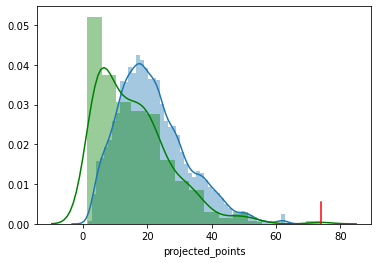

In [95]:
# contests(sport=Sport.NBA)
# draftables(draft_group_id=4)
# draft_group_details(draft_group_id=1)
# available_players(draft_group_id=4)
#make_predictions(datetime(2019, 11, 1), datetime(2020, 7, 31))
season_predictions = pd.read_csv("./AllCSVs/11_1_7_31_2020_predicted_box_scores.csv")
#actual_box_scores = box_scores_for_range_of_days(datetime(2019, 11, 1), datetime(2020, 7, 31))
actual_box_scores["made_two_point_field_goals"] = actual_box_scores["made_field_goals"] - actual_box_scores["made_three_point_field_goals"]
season_predictions = season_predictions[~season_predictions.date.str.contains("2019-11")]
season_predictions['projected_points'] = 3 * season_predictions["made_three_point_field_goals"] + 2 * season_predictions["made_two_point_field_goals"] + season_predictions["made_free_throws"] + 1.2 * season_predictions["rebounds"] + 1.5 * season_predictions["assists"] + 3 * season_predictions["blocks"] + 3 * season_predictions["steals"] - season_predictions["turnovers"]
actual_box_scores['actual_points'] = 3 * actual_box_scores["made_three_point_field_goals"] + 2 *actual_box_scores["made_two_point_field_goals"] + actual_box_scores["made_free_throws"] + 1.2 * (actual_box_scores["offensive_rebounds"] + actual_box_scores["defensive_rebounds"]) + 1.5 * actual_box_scores["assists"] + 3 * actual_box_scores["blocks"] + 3 * actual_box_scores["steals"] - actual_box_scores["turnovers"]
future_games = preds.append(preds_1)
sns.distplot(season_predictions["projected_points"])
#sns.distplot(actual_box_scores["actual_points"])
sns.distplot(future_games["projected_points"], color = "green")
pyplot.axvline(73.85, 0, .1, color = "red")

In [39]:
difficult_names_map_fanduel = {"Luka Dončić": "Luka Doncic", 
                       "Luka Šamanić": "Luka Samanic", 
                       "Kristaps Porziņģis": "Kristaps Porzingis", 
                       "Nikola Vučević": "Nikola Vucevic",
                       "Jonas Valančiūnas": "Jonas Valanciunas",
                       "Bogdan Bogdanović": "Bogdan Bogdanovic",
                       "Dario Šarić": "Dario Saric",
                       "Timothé Luwawu-Cabarrot": "Timothe Luwawu-Cabarrot",
                       "Džanan Musa": "Dzanan Musa",
                        "Dāvis Bertāns": "Davis Bertans",
                        "Boban Marjanović": "Boban Marjanovic",
                        "Ersan İlyasova": "Ersan Ilyasova",
                        "Anžejs Pasečņiks": "Anzejs Pasecniks",
                       "Bojan Bogdanović": "Bojan Bogdanovic",
                        "Nicolò Melli": "Nicolo Melli",
                       "Gary Payton": "Gary Payton II",
                       "Mohamed Bamba": "Mo Bamba",
                       "Wesley Iwundu": "Wes Iwundu",
                        "J.J. Redick": "JJ Redick",
                        "B.J. Johnson": "BJ Johnson"} #Check this for August 1

difficult_names_map_draftkings = {"Luka Dončić": "Luka Doncic", 
                       "Luka Šamanić": "Luka Samanic", 
                       "Kristaps Porziņģis": "Kristaps Porzingis", 
                       "Nikola Vučević": "Nikola Vucevic",
                       "Jonas Valančiūnas": "Jonas Valanciunas",
                       "Bogdan Bogdanović": "Bogdan Bogdanovic",
                       "Dario Šarić": "Dario Saric",
                       "Timothé Luwawu-Cabarrot": "Timothe Luwawu-Cabarrot",
                       "Džanan Musa": "Dzanan Musa",
                        "Boban Marjanović": "Boban Marjanovic",
                        "Ersan İlyasova": "Ersan Ilyasova",
                        "Anžejs Pasečņiks": "Anzejs Pasecniks",
                       "Bojan Bogdanović": "Bojan Bogdanovic",
                        "Dāvis Bertāns": "Davis Bertans",
                        "Nicolò Melli": "Nicolo Melli",
                       "Gary Payton": "Gary Payton II",
                       "Frank Mason": "Frank Mason III",
                       "Marvin Bagley": "Marvin Bagley III",
                       "James Ennis": "James Ennis III",
                       "Harry Giles": "Harry Giles III",
                        "Lonnie Walker": "Lonnie Walker IV",
                       "Mohamed Bamba": "Mo Bamba",
                       "Wesley Iwundu": "Wes Iwundu",
                        "J.J. Redick": "JJ Redick",
                        "B.J. Johnson": "BJ Johnson",
                        "Melvin Frazier": "Melvin Frazier Jr.",
                        "Gary Trent": "Gary Trent Jr.",
                        "Danuel House": "Danuel House Jr.",
                        "Tim Hardaway": "Tim Hardaway Jr.",
                        "Jaren Jackson": "Jaren Jackson Jr.",
                        "Kelly Oubre": "Kelly Oubre Jr.",
                        "Troy Brown": "Troy Brown Jr.",
                        "Marcus Morris": "Marcus Morris Sr."} #Check this for August 1

punctuation_names = {"Kentavious Caldwell Pope": "Kentavious Caldwell-Pope",
                    "Marcus Morris Sr.": "Marcus Morris"}

#august_1_predictions = predict_unplayed_games(datetime(2020, 1, 2), datetime(2020, 8, 1))
bronjuly30 = july_30_predictions[july_30_predictions["name"] == "LeBron James"]
(2 * bronjuly30["made_two_point_field_goals"] + 3 * bronjuly30["made_three_point_field_goals"] + bronjuly30["made_free_throws"], bronjuly30["rebounds"], bronjuly30["assists"], bronjuly30["blocks"], bronjuly30["steals"], bronjuly30["turnovers"])
july_31_predictions.sort_values(by="projected_points", ascending = False)

NameError: name 'july_31_predictions' is not defined

In [45]:
def optimal_lineup_fanduel_games(game_date, predictions, fanduel_csv, players_out = []):
    fanduel_data = pd.read_csv(fanduel_csv)
    print("Done predicting!")
    for i in predictions.index:
        if predictions.loc[i, "name"] in difficult_names_map_fanduel.keys():
            n = predictions.loc[i, "name"]
            predictions.loc[i, "name"] = difficult_names_map_fanduel[n]
    fanduel_data_with_predictions = fanduel_data.merge(predictions, left_on = "Nickname", right_on = "name").fillna(" ")
    fanduel_data_with_predictions["FPPG"] = fanduel_data_with_predictions["FPPG"].round(2)
    fanduel_data_with_predictions["Value above Market Value"] = fanduel_data_with_predictions["projected_value"] - fanduel_data_with_predictions["Salary"]
    fanduel_data_with_predictions["Value above Market Value"] = np.where(fanduel_data_with_predictions["Value above Market Value"] < 0, '-$' + fanduel_data_with_predictions["Value above Market Value"].astype(str).str[1:], '$' + fanduel_data_with_predictions["Value above Market Value"].astype(str))
    fanduel_data_with_predictions_injuries = fanduel_data_with_predictions[fanduel_data_with_predictions["Injury Indicator"] != "O"]
    players_not_out = [(name not in players_out) for name in fanduel_data_with_predictions_injuries["Nickname"]]
    fanduel_data_with_predictions_injuries = fanduel_data_with_predictions_injuries[players_not_out]
    fanduel_data_with_predictions_injuries.index = range(fanduel_data_with_predictions_injuries.shape[0])
    #print(fanduel_data_with_predictions_injuries)
    values = fanduel_data_with_predictions_injuries["projected_points"]
    players = fanduel_data_with_predictions_injuries["Nickname"]
    positions = fanduel_data_with_predictions_injuries["Position"]
    costs = fanduel_data_with_predictions_injuries["Salary"]
    data_to_feed = pd.DataFrame(data = {'players': players, 'positions': positions, 'values': values, 'costs': costs})
    optimal_lineup = [n.replace("_", " ") for n in generate_optimal_lineup(players, positions, values, costs, 60000)]
    for i in range(len(optimal_lineup)):
        if optimal_lineup[i] in punctuation_names.keys():
            optimal_lineup[i] = punctuation_names[optimal_lineup[i]]
    fanduel_data_with_predictions_injuries["projected_value"] = ['$' + str(s) for s in fanduel_data_with_predictions_injuries["projected_value"]]
    fanduel_data_with_predictions_injuries["Salary"] = ['$' + str(s) for s in fanduel_data_with_predictions_injuries["Salary"]]
    projs_in_optimal = [(fanduel_data_with_predictions_injuries.loc[i, "Nickname"] in optimal_lineup) for i in fanduel_data_with_predictions_injuries.index]
    lineup_return = fanduel_data_with_predictions_injuries[projs_in_optimal].sort_values(by=["Position"], ascending = False)
    lineup_return = lineup_return.loc[:, ["Nickname", "Position", "Game", "Team", 'projected_points', 'projected_value', "Salary", "Value above Market Value", 'projected_points_draftkings', 'projected_value_draftkings', "FPPG", '10_game_average', '3_game_average', "Injury Indicator", "Injury Details", "minutes", "made_two_point_field_goals", 'made_three_point_field_goals',
       'made_free_throws', 'rebounds', 'assists', 'blocks', 'steals', 'turnovers','hot', 'cold']]
    lineup_return.columns = ["Name", "Position", "Game", "Team", 'Projected Fanduel Points', 'Projected Fanduel Value', "Fanduel Salary",  "Value above Fanduel Value", 'Projected Draftkings Points', 'Projected Draftkings Value', "FPPG (Fanduel)", '10 Game Average (Fanduel)', '3 Game Average (Fanduel)', "Injury Indicator", "Injury Details", "Minutes", "2PT FG", '3PT FG',
       'FTM', 'Rebounds', 'Assists', 'Blocks', 'Steals', 'Turnovers','Hot', 'Cold']
    csv_return = fanduel_data_with_predictions.loc[:, ["Nickname", "Position", "Game", "Team", 'projected_points', 'projected_value', "Salary", "Value above Market Value", 'projected_points_draftkings', 'projected_value_draftkings', "FPPG", '10_game_average', '3_game_average', "Injury Indicator", "Injury Details", "minutes", "made_two_point_field_goals", 'made_three_point_field_goals',
       'made_free_throws', 'rebounds', 'assists', 'blocks', 'steals', 'turnovers', "Opponent Defensive Rank vs Position", 'hot', 'cold']]
    csv_return.columns = ["Name", "Position", "Game", "Team", 'Projected Fanduel Points', 'Projected Fanduel Value', "Fanduel Salary", "Value above Fanduel Value", 'Projected Draftkings Points', 'Projected Draftkings Value', "FPPG (Fanduel)", '10 Game Average (Fanduel)', '3 Game Average (Fanduel)', "Injury Indicator", "Injury Details", "Minutes", "2PT FG", '3PT FG',
       'FTM', 'Rebounds', 'Assists', 'Blocks', 'Steals', 'Turnovers', "Opponent Defensive Rank vs Position", 'Hot', 'Cold']
    csv_return_dfs = csv_return.loc[:, ["Name", "Position", "Game", "Team", 'Projected Fanduel Points', 'Projected Fanduel Value', "Fanduel Salary", "Value above Fanduel Value", 'Projected Draftkings Points', 'Projected Draftkings Value', "FPPG (Fanduel)", '10 Game Average (Fanduel)', '3 Game Average (Fanduel)', "Opponent Defensive Rank vs Position",  "Injury Indicator", "Injury Details", 'Hot', 'Cold']]
    csv_return_projections = csv_return.loc[:, ["Name", "Position", "Game", "Team", "Minutes", "2PT FG", '3PT FG',
       'FTM', 'Rebounds', 'Assists', 'Blocks', 'Steals', 'Turnovers', "Opponent Defensive Rank vs Position", "Injury Indicator", "Injury Details"]]
    lineup_return = lineup_return.loc[:, ["Name", "Position", "Game", "Team", 'Projected Fanduel Points', 'Projected Fanduel Value', "Fanduel Salary", "Value above Fanduel Value", "FPPG (Fanduel)", "Injury Indicator", "Injury Details", 'Hot', 'Cold']]
    
    csv_return_dfs.to_csv("./AllCSVs/dfs_projections_to_display_" + str(game_date.month) + "_" + str(game_date.day) + "_" + str(game_date.year) + ".csv")
    csv_return_projections.to_csv("./AllCSVs/statline_projections_to_display_" + str(game_date.month) + "_" + str(game_date.day) + "_" + str(game_date.year) + ".csv")
    lineup_return.to_csv("./AllCSVs/optimal_fanduel_lineup_" + str(game_date.month) + "_" + str(game_date.day) + "_" + str(game_date.year) + ".csv")
    return csv_return_dfs, csv_return_projections, lineup_return

def optimal_lineup_draftkings_games(game_date, predictions, draftkings_csv, players_out = []):
    draftkings_data = pd.read_csv(draftkings_csv)
    print("Done predicting!")
    for i in predictions.index:
        if predictions.loc[i, "name"] in difficult_names_map_draftkings.keys():
            n = predictions.loc[i, "name"]
            predictions.loc[i, "name"] = difficult_names_map_draftkings[n]
    draftkings_data_with_predictions = draftkings_data.merge(predictions, left_on = "Name", right_on = "name")
    draftkings_data_with_predictions["AvgPointsPerGame"] = draftkings_data_with_predictions["AvgPointsPerGame"].round(2)
    draftkings_data_with_predictions["Game Info"] = [g[:7] for g in draftkings_data_with_predictions["Game Info"]]
    draftkings_data_with_predictions["Value above Market Value"] = draftkings_data_with_predictions["projected_value_draftkings"] - draftkings_data_with_predictions["Salary"]
    draftkings_data_with_predictions["Value above Market Value"] = np.where(draftkings_data_with_predictions["Value above Market Value"] < 0, '-$' + draftkings_data_with_predictions["Value above Market Value"].astype(str).str[1:], '$' + draftkings_data_with_predictions["Value above Market Value"].astype(str))
    draftkings_data_with_predictions_injuries = draftkings_data_with_predictions#[draftkings_data_with_predictions["Injury Indicator"] != "O"]
    players_not_out = [(name not in players_out) for name in draftkings_data_with_predictions_injuries["Name"]]
    draftkings_data_with_predictions_injuries = draftkings_data_with_predictions_injuries[players_not_out]
    draftkings_data_with_predictions_injuries.index = range(draftkings_data_with_predictions_injuries.shape[0])
    #print(fanduel_data_with_predictions_injuries)
    values = draftkings_data_with_predictions_injuries["projected_points_draftkings"]
    players = draftkings_data_with_predictions_injuries["Name"]
    positions_as_lists = [list(st.split("/")) for st in draftkings_data_with_predictions_injuries["Position"]]
    positions = draftkings_data_with_predictions_injuries["Position"]
    costs = draftkings_data_with_predictions_injuries["Salary"]
    data_to_feed = pd.DataFrame(data = {'players': players, 'positions': positions_as_lists, 'values': values, 'costs': costs})
    optimal_lineup = [n.replace("_", " ") for n in generate_optimal_lineup_draftkings(players, positions_as_lists, values, costs, 50000)]
    for i in range(len(optimal_lineup)):
        if optimal_lineup[i] in punctuation_names.keys():
            optimal_lineup[i] = punctuation_names[optimal_lineup[i]]
    draftkings_data_with_predictions_injuries["projected_value_draftkings"] = ['$' + str(s) for s in draftkings_data_with_predictions_injuries["projected_value_draftkings"]]
    draftkings_data_with_predictions_injuries["Salary"] = ['$' + str(s) for s in draftkings_data_with_predictions_injuries["Salary"]]
    projs_in_optimal = [(draftkings_data_with_predictions_injuries.loc[i, "Name"] in optimal_lineup) for i in draftkings_data_with_predictions_injuries.index]
    lineup_return = draftkings_data_with_predictions_injuries[projs_in_optimal].sort_values(by=["Position"], ascending = False)
    lineup_return = lineup_return.loc[:, ["Name", "Position", "Game Info", "TeamAbbrev", 'projected_points', 'projected_value', 'projected_points_draftkings', 'projected_value_draftkings', "Salary", "Value above Market Value", "AvgPointsPerGame", '10_game_average', '3_game_average', "Injury Indicator", "Injury Details", "minutes", "made_two_point_field_goals", 'made_three_point_field_goals',
       'made_free_throws', 'rebounds', 'assists', 'blocks', 'steals', 'turnovers','hot', 'cold']].fillna(" ")
    lineup_return.columns = ["Name", "Position", "Game", "Team", 'Projected Fanduel Points', 'Projected Fanduel Value', 'Projected Draftkings Points', 'Projected Draftkings Value', "Draftkings Salary", "Value above Draftkings Value", "FPPG", '10 Game Average (Fanduel)', '3 Game Average (Fanduel)', "Injury Indicator", "Injury Details", "Minutes", "2PT FG", '3PT FG',
       'FTM', 'Rebounds', 'Assists', 'Blocks', 'Steals', 'Turnovers','Hot', 'Cold']
    csv_return = draftkings_data_with_predictions.loc[:, ["Name", "Position", "Salary", "Game Info", "TeamAbbrev", 'projected_points', 'projected_value', "Value above Market Value", 'projected_points_draftkings', 'projected_value_draftkings', "AvgPointsPerGame", '10_game_average', '3_game_average', "Injury Indicator", "Injury Details", "minutes", "made_two_point_field_goals", 'made_three_point_field_goals',
       'made_free_throws', 'rebounds', 'assists', 'blocks', 'steals', 'turnovers', "Opponent Defensive Rank vs Position", 'hot', 'cold']].fillna(" ")
    csv_return.columns = ["Name", "Position", "Salary", "Game", "Team", 'Projected Fanduel Points', 'Projected Fanduel Value', "Value above Fanduel Value", 'Projected Draftkings Points', 'Projected Draftkings Value', "FPPG", '10 Game Average (Fanduel)', '3 Game Average (Fanduel)', "Injury Indicator", "Injury Details", "Minutes", "2PT FG", '3PT FG',
       'FTM', 'Rebounds', 'Assists', 'Blocks', 'Steals', 'Turnovers', "Opponent Defensive Rank vs Position", 'Hot', 'Cold']
    csv_return_dfs = csv_return.loc[:, ["Name", "Position", "Salary", "Game", "Team", 'Projected Fanduel Points', 'Projected Fanduel Value', "Value above Fanduel Value", 'Projected Draftkings Points', 'Projected Draftkings Value', "FPPG", '10 Game Average (Fanduel)', '3 Game Average (Fanduel)', "Opponent Defensive Rank vs Position", "Injury Indicator", "Injury Details", 'Hot', 'Cold']]
    csv_return_projections = csv_return.loc[:, ["Name", "Position", "Game", "Team", "Minutes", "2PT FG", '3PT FG',
       'FTM', 'Rebounds', 'Assists', 'Blocks', 'Steals', 'Turnovers', "Opponent Defensive Rank vs Position", "Injury Indicator", "Injury Details"]]
    lineup_return = lineup_return.loc[:, ["Name", "Position", "Game", "Team", 'Projected Draftkings Points', 'Projected Draftkings Value', "Draftkings Salary", "Value above Draftkings Value", "FPPG", "Injury Indicator", "Injury Details", 'Hot', 'Cold']]
    
    fanduel_statlines = pd.read_csv("./AllCSVs/statline_projections_to_display_" + str(game_date.month) + "_" + str(game_date.day) + "_" + str(game_date.year) + ".csv").fillna(" ")
    injury_indicators = []
    injury_details = []
    for i in lineup_return.index:
        print(lineup_return.loc[i, "Name"])
        for n in fanduel_statlines.index:
            if fanduel_statlines.loc[n, "Name"] == lineup_return.loc[i, "Name"]:
                print(i)
                injury_indicators.append(fanduel_statlines.loc[n, "Injury Indicator"])
                injury_details.append(fanduel_statlines.loc[n, "Injury Details"])
            elif lineup_return.loc[i, "Name"] in punctuation_names.keys():
                if punctuation_names[lineup_return.loc[i, "Name"]] == fanduel_statline.loc[n, "Name"]:
                    print(i)
                    injury_indicators.append(fanduel_statlines.loc[n, "Injury Indicator"])
                    injury_details.append(fanduel_statlines.loc[n, "Injury Details"])
    lineup_return["Injury Indicator"] = injury_indicators
    lineup_return["Injury Details"] = injury_details
    
    lineup_return.to_csv("./AllCSVs/optimal_draftkings_lineup_" + str(game_date.month) + "_" + str(game_date.day) + "_" + str(game_date.year) + ".csv")
    return csv_return_dfs, csv_return_projections, lineup_return

preds = pd.read_csv("./AllCSVs/predictions_for_07_30_2020_unplayed.csv")
preds_1 = pd.read_csv("./AllCSVs/predictions_for_07_31_2020_unplayed.csv")

fd_csv = "./AllCSVs/FanDuel-NBA-2020-07-30-46677-players-list.csv"
fd_csv_1 = "./AllCSVs/FanDuel-NBA-2020-07-31-46839-players-list.csv"

dk_csv = "./AllCSVs/DKSalaries_07302020.csv"
dk_csv_1 = "./AllCSVs/DKSalaries_07312020.csv"

preds310 = pd.read_csv("./AllCSVs/predictions_for_03_10_from_1_19_2020.csv")
preds309 = pd.read_csv("./AllCSVs/predictions_for_03_09_from_1_19_2020.csv")
# playerlist730 = pd.read_csv(dk_csv)
# print(playerlist731[~playerlist731["Name"].isin(preds_1.name)])
# print(playerlist730[~playerlist730["Name"].isin(preds.name)])

optimal_lineup_draftkings_games(datetime(2020, 7, 30), preds, dk_csv, ["Lou Williams", "Bojan Bogdanovic", "Avery Bradley", "Montrezl Harrell"])[2]

Done predicting!


c:\users\waldm\appdata\local\programs\python\python36-32\lib\site-packages\pulp\pulp.py:1137: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")
c:\users\waldm\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\waldm\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\waldm\appda

Kyle Kuzma
16
Kawhi Leonard
2
Donovan Mitchell
9
LeBron James
0
Lonzo Ball
6
JaMychal Green
27
Ivica Zubac
17
Dwight Howard
31


,Name,Position,Game,Team,Projected Draftkings Points,Projected Draftkings Value,Draftkings Salary,Value above Draftkings Value,FPPG,Injury Indicator,Injury Details,Hot,Cold
16,Kyle Kuzma,SF/PF,LAC@LAL,LAL,25.28,$4740,$4500,$240,21.47,GTD,Ankle,0.0,0.000000
2,Kawhi Leonard,SF,LAC@LAL,LAC,52.40,$9825,$9200,$625,48.42,,,0.0,0.000000
9,Donovan Mitchell,PG/SG,UTA@NO,UTA,38.90,$7295,$7000,$295,38.38,,,0.0,1.150799
0,LeBron James,PG/SF,LAC@LAL,LAL,78.12,$14648,$10700,$3948,55.77,GTD,Groin,0.0,0.000000
6,Lonzo Ball,PG,UTA@NO,NO,38.71,$7258,$7400,-$142,34.80,,,0.0,0.000000
27,JaMychal Green,PF,LAC@LAL,LAC,20.53,$3850,$3500,$350,17.64,,,0.0,0.000000
17,Ivica Zubac,C,LAC@LAL,LAC,27.54,$5165,$4500,$665,20.64,,,0.0,0.000000
31,Dwight Howard,C,LAC@LAL,LAL,17.77,$3331,$3200,$131,20.73,,,0.0,3.186799


In [47]:
def regression_by_sample(start_date, end_date, sample_size, weight):
    full_df = box_scores_for_range_of_days(start_date, end_date)
    weighted_statlines = statline_predictor(full_df, input_statistics, sample_size, weight)
    weighted_statlines_to_keep = weighted_statlines[weighted_statlines.seconds_played > 1000]
    df_to_keep = full_df[weighted_statlines.seconds_played > 1000]
    df_to_keep["attempted_two_point_field_goals"] = df_to_keep["attempted_field_goals"] - df_to_keep["attempted_three_point_field_goals"]
    df_to_keep["made_two_point_field_goals"] = df_to_keep["made_field_goals"] - df_to_keep["made_three_point_field_goals"]
    weighted_statlines_to_keep['name_date'] = weighted_statlines_to_keep["name"] + weighted_statlines_to_keep["date"].astype(str)
    df_to_keep['name_date'] = df_to_keep["name"] + df_to_keep["Date"].astype(str)
    df_merged = weighted_statlines_to_keep.merge(df_to_keep, left_on = 'name_date', right_on = 'name_date')
    df_merged["rebounds_y"] = df_merged["offensive_rebounds_y"] + df_merged["defensive_rebounds_y"]
    df_merged["location_x"] = df_merged["location_x"] == "HOME"
    df_merged["location_y"] = df_merged["location_y"] == "HOME"
    print(df_merged.columns)
    df_merged["fantasy_points"] = [float(get_points(df_merged[df_merged["name_date"] == player_name])[0]) for player_name in df_merged["name_date"]]
    df_merged = df_merged[df_merged.Date.astype(str).str.contains("2020-02")]
    predictors = df_merged.iloc[:,[3, 7, 6, 9, 10, 12, 11, 13, 14, 15, 18, 16, 17, 22, 23, 24, 20, 25, 21]]
    print(df_merged.columns[[3, 7, 6, 9, 10, 12, 11, 13, 14, 15, 18, 16, 17, 22, 23, 24, 20, 25, 21]])
    print(len(df_merged.columns), df_merged.columns)
    for desired_output in [33, 36, 38, 42, 43, 44, 45, 46, 56, 57]:
        y = df_merged.iloc[:,desired_output]
        pred_train, pred_test, y_train, y_test = train_test_split(predictors, y, test_size=0.2, random_state=8573)
        pred_train1, pred_test1, y_train1, y_test1 = train_test_split(predictors, y, test_size=0.2, random_state=43)
        pred_train2, pred_test2, y_train2, y_test2 = train_test_split(predictors, y, test_size=0.2, random_state=9623)
        pred_train3, pred_test3, y_train3, y_test3 = train_test_split(predictors, y, test_size=0.2, random_state=7643)
        pred_train4, pred_test4, y_train4, y_test4 = train_test_split(predictors, y, test_size=0.2, random_state=55553)
        pred_train5, pred_test5, y_train5, y_test5 = train_test_split(predictors, y, test_size=0.2, random_state=517433)
        pred_train6, pred_test6, y_train6, y_test6 = train_test_split(predictors, y, test_size=0.2, random_state=993)
        ridge_model = RidgeCV().fit(pred_train, y_train)
        #linear_model = GradientBoostingRegressor().fit(pred_train, y_train)
        ridge_model1 = RidgeCV().fit(pred_train1, y_train1)
        #linear_model1 = GradientBoostingRegressor().fit(pred_train1, y_train1)
        ridge_model2 = RidgeCV().fit(pred_train2, y_train2)
        #linear_model2 = GradientBoostingRegressor().fit(pred_train2, y_train2)
        ridge_model3 = RidgeCV().fit(pred_train3, y_train3)
        #linear_model3 = GradientBoostingRegressor().fit(pred_train3, y_train3)
        ridge_model4 = RidgeCV().fit(pred_train4, y_train4)
        #linear_model4 = GradientBoostingRegressor().fit(pred_train4, y_train4)
        ridge_model5 = RidgeCV().fit(pred_train5, y_train5)
        #linear_model5 = GradientBoostingRegressor().fit(pred_train5, y_train5)
        ridge_model6 = RidgeCV().fit(pred_train6, y_train6)
        #linear_model6 = GradientBoostingRegressor().fit(pred_train6, y_train6)
        print(df_merged.columns[desired_output])
        print(np.mean((ridge_model.predict(pred_test) - y_test)**2))
        #print(linear_model.score(pred_test, y_test))
        print(np.mean((ridge_model1.predict(pred_test1) - y_test1)**2))
        #print(linear_model1.score(pred_test1, y_test1))
        print(np.mean((ridge_model2.predict(pred_test2) - y_test2)**2))
        #print(linear_model2.score(pred_test2, y_test2))
        print(np.mean((ridge_model3.predict(pred_test3) - y_test3)**2))
        #print(linear_model3.score(pred_test3, y_test3))
        print(np.mean((ridge_model4.predict(pred_test4) - y_test4)**2))
        #print(linear_model4.score(pred_test4, y_test4))
        print(np.mean((ridge_model5.predict(pred_test5) - y_test5)**2))
        #print(linear_model5.score(pred_test5, y_test5))
        print(np.mean((ridge_model6.predict(pred_test6) - y_test6)**2))
        #print(linear_model6.score(pred_test6, y_test6))
    #return df_merged
for i, j in [(8, .85), (8, .9)]:#[(7, .9), (8, .8), (8, .85), (8, .9)]:
         regression_by_sample(datetime(2019, 12, 2), datetime(2020, 3, 1), i, j)

c:\users\waldm\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
c:\users\waldm\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
c:\users\waldm\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

Index(['name_x', 'team_x', 'date', 'location_x', 'opponent_x',
       'made_field_goals_x', 'made_two_point_field_goals_x',
       'attempted_two_point_field_goals_x', 'attempted_field_goals_x',
       'made_three_point_field_goals_x', 'attempted_three_point_field_goals_x',
       'attempted_free_throws_x', 'made_free_throws_x', 'offensive_rebounds_x',
       'defensive_rebounds_x', 'assists_x', 'blocks_x', 'turnovers_x',
       'steals_x', 'seconds_played_x', 'Opponent Defensive Rating_x',
       'Opponent Turnover %_x', 'Team Defensive Rating_x', 'Team Pace_x',
       'Team Turnover %_x', 'Opponent Pace_x', 'name_date', 'slug', 'name_y',
       'team_y', 'location_y', 'opponent_y', 'outcome', 'seconds_played_y',
       'made_field_goals_y', 'attempted_field_goals_y',
       'made_three_point_field_goals_y', 'attempted_three_point_field_goals_y',
       'made_free_throws_y', 'attempted_free_throws_y', 'offensive_rebounds_y',
       'defensive_rebounds_y', 'assists_y', 'steals_y', 'blo

c:\users\waldm\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
c:\users\waldm\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
c:\users\waldm\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

Index(['name_x', 'team_x', 'date', 'location_x', 'opponent_x',
       'made_field_goals_x', 'made_two_point_field_goals_x',
       'attempted_two_point_field_goals_x', 'attempted_field_goals_x',
       'made_three_point_field_goals_x', 'attempted_three_point_field_goals_x',
       'attempted_free_throws_x', 'made_free_throws_x', 'offensive_rebounds_x',
       'defensive_rebounds_x', 'assists_x', 'blocks_x', 'turnovers_x',
       'steals_x', 'seconds_played_x', 'Opponent Defensive Rating_x',
       'Opponent Turnover %_x', 'Team Defensive Rating_x', 'Team Pace_x',
       'Team Turnover %_x', 'Opponent Pace_x', 'name_date', 'slug', 'name_y',
       'team_y', 'location_y', 'opponent_y', 'outcome', 'seconds_played_y',
       'made_field_goals_y', 'attempted_field_goals_y',
       'made_three_point_field_goals_y', 'attempted_three_point_field_goals_y',
       'made_free_throws_y', 'attempted_free_throws_y', 'offensive_rebounds_y',
       'defensive_rebounds_y', 'assists_y', 'steals_y', 'blo

In [48]:
#july_30_predictions.groupby(["team"]).sum()
#july_30_predictions[july_30_predictions["team"] == "LOS ANGELES CLIPPERS"]
#sns.distplot(jan_25_pred_actual.predicted_points)
#sns.distplot(jan_25_pred_actual.actual_points)
#sns.jointplot(data = jan_25_pred_actual, x = "predicted_points", y = "actual_points", kind = 'reg')
#jan_24_pred_actual["blended_prediction"] = .7*jan_24_pred_actual["recent_average"] + .3*jan_24_pred_actual["predicted_points"]
#feb_12_pred_actual_sig = feb_12_pred_actual[feb_12_pred_actual["minutes"] <= 19]

#print(r2_score(feb_25_pred_actual.fantasy_points_8_9, feb_25_pred_actual.actual_points), r2_score(feb_25_pred_actual.predicted_points, feb_25_pred_actual.actual_points))
#print(r2_score(feb_26_pred_actual.fantasy_points_8_9, feb_26_pred_actual.actual_points), r2_score(feb_26_pred_actual.predicted_points, feb_26_pred_actual.actual_points))
#print(r2_score(feb_27_pred_actual.fantasy_points_8_9, feb_27_pred_actual.actual_points), r2_score(feb_27_pred_actual.predicted_points, feb_27_pred_actual.actual_points))
#print(r2_score(feb_28_pred_actual.fantasy_points_8_9, feb_28_pred_actual.actual_points), r2_score(feb_28_pred_actual.predicted_points, feb_28_pred_actual.actual_points))

#sns.jointplot(data = mar_7_pred_actual, x = "fantasy_points_8_9", y = "predicted_points", kind = 'reg')

# print(len(july_30_predictions[july_30_predictions["hot"] > 0])/len(july_30_predictions))
# print(len(july_30_predictions[july_30_predictions["cold"] > 0])/len(july_30_predictions))
#sns.distplot(july_31_predictions.hot)
# july_30_predictions[july_30_predictions["hot"] > 0]
#july_31_predictions[july_31_predictions["cold"] > 0]

# print(r2_score(mar_1_pred_actual.fantasy_points_7_9, mar_1_pred_actual.actual_points), r2_score(mar_1_pred_actual.fantasy_points_8_8, mar_1_pred_actual.actual_points), r2_score(mar_1_pred_actual.fantasy_points_8_85, mar_1_pred_actual.actual_points), r2_score(mar_1_pred_actual.fantasy_points_8_9, mar_1_pred_actual.actual_points), r2_score(mar_1_pred_actual.predicted_points, mar_1_pred_actual.actual_points))
# print(r2_score(mar_2_pred_actual.fantasy_points_7_9, mar_2_pred_actual.actual_points), r2_score(mar_2_pred_actual.fantasy_points_8_8, mar_2_pred_actual.actual_points), r2_score(mar_2_pred_actual.fantasy_points_8_85, mar_2_pred_actual.actual_points), r2_score(mar_2_pred_actual.fantasy_points_8_9, mar_2_pred_actual.actual_points), r2_score(mar_2_pred_actual.predicted_points, mar_2_pred_actual.actual_points))
# print(r2_score(mar_3_pred_actual.fantasy_points_7_9, mar_3_pred_actual.actual_points), r2_score(mar_3_pred_actual.fantasy_points_8_8, mar_3_pred_actual.actual_points), r2_score(mar_3_pred_actual.fantasy_points_8_85, mar_3_pred_actual.actual_points), r2_score(mar_3_pred_actual.fantasy_points_8_9, mar_3_pred_actual.actual_points), r2_score(mar_3_pred_actual.predicted_points, mar_3_pred_actual.actual_points))
# print(r2_score(mar_4_pred_actual.fantasy_points_7_9, mar_4_pred_actual.actual_points), r2_score(mar_4_pred_actual.fantasy_points_8_8, mar_4_pred_actual.actual_points), r2_score(mar_4_pred_actual.fantasy_points_8_85, mar_4_pred_actual.actual_points), r2_score(mar_4_pred_actual.fantasy_points_8_9, mar_4_pred_actual.actual_points), r2_score(mar_4_pred_actual.predicted_points, mar_4_pred_actual.actual_points))
# print(r2_score(mar_5_pred_actual.fantasy_points_7_9, mar_5_pred_actual.actual_points), r2_score(mar_5_pred_actual.fantasy_points_8_8, mar_5_pred_actual.actual_points), r2_score(mar_5_pred_actual.fantasy_points_8_85, mar_5_pred_actual.actual_points), r2_score(mar_5_pred_actual.fantasy_points_8_9, mar_5_pred_actual.actual_points), r2_score(mar_5_pred_actual.predicted_points, mar_5_pred_actual.actual_points))
# print(r2_score(mar_6_pred_actual.fantasy_points_7_9, mar_6_pred_actual.actual_points), r2_score(mar_6_pred_actual.fantasy_points_8_8, mar_6_pred_actual.actual_points), r2_score(mar_6_pred_actual.fantasy_points_8_85, mar_6_pred_actual.actual_points), r2_score(mar_6_pred_actual.fantasy_points_8_9, mar_6_pred_actual.actual_points), r2_score(mar_6_pred_actual.predicted_points, mar_6_pred_actual.actual_points))
# print(r2_score(mar_7_pred_actual.fantasy_points_7_9, mar_7_pred_actual.actual_points), r2_score(mar_7_pred_actual.fantasy_points_8_8, mar_7_pred_actual.actual_points), r2_score(mar_7_pred_actual.fantasy_points_8_85, mar_7_pred_actual.actual_points), r2_score(mar_7_pred_actual.fantasy_points_8_9, mar_7_pred_actual.actual_points), r2_score(mar_7_pred_actual.predicted_points, mar_7_pred_actual.actual_points))
# print(r2_score(mar_8_pred_actual.fantasy_points_7_9, mar_8_pred_actual.actual_points), r2_score(mar_8_pred_actual.fantasy_points_8_8, mar_8_pred_actual.actual_points), r2_score(mar_8_pred_actual.fantasy_points_8_85, mar_8_pred_actual.actual_points), r2_score(mar_8_pred_actual.fantasy_points_8_9, mar_8_pred_actual.actual_points), r2_score(mar_8_pred_actual.predicted_points, mar_8_pred_actual.actual_points))
# print(r2_score(mar_9_pred_actual.fantasy_points_7_9, mar_9_pred_actual.actual_points), r2_score(mar_9_pred_actual.fantasy_points_8_8, mar_9_pred_actual.actual_points), r2_score(mar_9_pred_actual.fantasy_points_8_85, mar_9_pred_actual.actual_points), r2_score(mar_9_pred_actual.fantasy_points_8_9, mar_9_pred_actual.actual_points), r2_score(mar_9_pred_actual.predicted_points, mar_9_pred_actual.actual_points))
# print(r2_score(mar_10_pred_actual.fantasy_points_7_9, mar_10_pred_actual.actual_points), r2_score(mar_10_pred_actual.fantasy_points_8_8, mar_10_pred_actual.actual_points), r2_score(mar_10_pred_actual.fantasy_points_8_85, mar_10_pred_actual.actual_points), r2_score(mar_10_pred_actual.fantasy_points_8_9, mar_10_pred_actual.actual_points), r2_score(mar_10_pred_actual.predicted_points, mar_10_pred_actual.actual_points))
# print(np.mean([r2_score(mar_1_pred_actual.fantasy_points_7_9, mar_1_pred_actual.actual_points), r2_score(mar_2_pred_actual.fantasy_points_7_9, mar_2_pred_actual.actual_points), r2_score(mar_3_pred_actual.fantasy_points_7_9, mar_3_pred_actual.actual_points), r2_score(mar_4_pred_actual.fantasy_points_7_9, mar_4_pred_actual.actual_points), r2_score(mar_5_pred_actual.fantasy_points_7_9, mar_5_pred_actual.actual_points), r2_score(mar_6_pred_actual.fantasy_points_7_9, mar_6_pred_actual.actual_points), r2_score(mar_7_pred_actual.fantasy_points_7_9, mar_7_pred_actual.actual_points), r2_score(mar_8_pred_actual.fantasy_points_7_9, mar_8_pred_actual.actual_points), r2_score(mar_9_pred_actual.fantasy_points_7_9, mar_9_pred_actual.actual_points), r2_score(mar_10_pred_actual.fantasy_points_7_9, mar_10_pred_actual.actual_points)]))
# print(np.mean([r2_score(mar_1_pred_actual.fantasy_points_8_8, mar_1_pred_actual.actual_points), r2_score(mar_2_pred_actual.fantasy_points_8_8, mar_2_pred_actual.actual_points), r2_score(mar_3_pred_actual.fantasy_points_8_8, mar_3_pred_actual.actual_points), r2_score(mar_4_pred_actual.fantasy_points_8_8, mar_4_pred_actual.actual_points), r2_score(mar_5_pred_actual.fantasy_points_8_8, mar_5_pred_actual.actual_points), r2_score(mar_6_pred_actual.fantasy_points_8_8, mar_6_pred_actual.actual_points), r2_score(mar_7_pred_actual.fantasy_points_8_8, mar_7_pred_actual.actual_points), r2_score(mar_8_pred_actual.fantasy_points_8_8, mar_8_pred_actual.actual_points), r2_score(mar_9_pred_actual.fantasy_points_8_8, mar_9_pred_actual.actual_points), r2_score(mar_10_pred_actual.fantasy_points_8_8, mar_10_pred_actual.actual_points)]))
# print(np.mean([r2_score(mar_1_pred_actual.fantasy_points_8_85, mar_1_pred_actual.actual_points), r2_score(mar_2_pred_actual.fantasy_points_8_85, mar_2_pred_actual.actual_points), r2_score(mar_3_pred_actual.fantasy_points_8_85, mar_3_pred_actual.actual_points), r2_score(mar_4_pred_actual.fantasy_points_8_85, mar_4_pred_actual.actual_points), r2_score(mar_5_pred_actual.fantasy_points_8_85, mar_5_pred_actual.actual_points), r2_score(mar_6_pred_actual.fantasy_points_8_85, mar_6_pred_actual.actual_points), r2_score(mar_7_pred_actual.fantasy_points_8_85, mar_7_pred_actual.actual_points), r2_score(mar_8_pred_actual.fantasy_points_8_85, mar_8_pred_actual.actual_points), r2_score(mar_9_pred_actual.fantasy_points_8_85, mar_9_pred_actual.actual_points), r2_score(mar_10_pred_actual.fantasy_points_8_85, mar_10_pred_actual.actual_points)]))
# print(np.mean([r2_score(mar_1_pred_actual.fantasy_points_8_9, mar_1_pred_actual.actual_points), r2_score(mar_2_pred_actual.fantasy_points_8_9, mar_2_pred_actual.actual_points), r2_score(mar_3_pred_actual.fantasy_points_8_9, mar_3_pred_actual.actual_points), r2_score(mar_4_pred_actual.fantasy_points_8_9, mar_4_pred_actual.actual_points), r2_score(mar_5_pred_actual.fantasy_points_8_9, mar_5_pred_actual.actual_points), r2_score(mar_6_pred_actual.fantasy_points_8_9, mar_6_pred_actual.actual_points), r2_score(mar_7_pred_actual.fantasy_points_8_9, mar_7_pred_actual.actual_points), r2_score(mar_8_pred_actual.fantasy_points_8_9, mar_8_pred_actual.actual_points), r2_score(mar_9_pred_actual.fantasy_points_8_9, mar_9_pred_actual.actual_points), r2_score(mar_10_pred_actual.fantasy_points_8_9, mar_10_pred_actual.actual_points)]))
# print(np.mean([r2_score(mar_1_pred_actual.predicted_points, mar_1_pred_actual.actual_points), r2_score(mar_2_pred_actual.predicted_points, mar_2_pred_actual.actual_points), r2_score(mar_3_pred_actual.predicted_points, mar_3_pred_actual.actual_points), r2_score(mar_4_pred_actual.predicted_points, mar_4_pred_actual.actual_points), r2_score(mar_5_pred_actual.predicted_points, mar_5_pred_actual.actual_points), r2_score(mar_6_pred_actual.predicted_points, mar_6_pred_actual.actual_points), r2_score(mar_7_pred_actual.predicted_points, mar_7_pred_actual.actual_points), r2_score(mar_8_pred_actual.predicted_points, mar_8_pred_actual.actual_points), r2_score(mar_9_pred_actual.predicted_points, mar_9_pred_actual.actual_points), r2_score(mar_10_pred_actual.predicted_points, mar_10_pred_actual.actual_points)]))
#np.mean(jan_24_pred_actual["recent_average"]), np.mean(jan_24_pred_actual["predicted_points"]), np.mean(jan_24_pred_actual["actual_points"])
#r2_score(july_31_predictions["recent_average"], july_31_predictions["projected_points"])
#r2_score(jan_24_pred_actual["recent_average"], jan_24_pred_actual["predicted_points"])

In [47]:
unlisted_players = {"Jamal Crawford": ["SG", 17],
               "Zach Collins": ["C", 18],
               "Al-Farouq Aminu": ["SF", 16],
               "Frank Kaminsky": ["PF", 19],
               "Tyler Zeller": ["C", 10],
               "Jerian Grant": ["PG", 12],
               "Josh Reaves": ["SG", 1],
               "Trey Burke": ["PG", 7],
               "Jonathan Isaac": ["PF", 19],
               "Cameron Payne": ["PG", 12],
               "Corey Brewer": ["SF", 11],
               "Jaylen Adams": ["PG", 9],
               "Jontay Porter": ["PF", 1],
               "Kyle Guy": ["SG", 2],
               "Grayson Allen": ["SG", 12],
               "Nicolo Melli": ["C", 11.2],
               "JR Smith": ["SG", 15.8],
               "Joakim Noah": ["C", 1.9],
               "Kenrich Williams": ["SF", 8.1],
               "Dion Waiters": ["SF", 8.3],
               "Talen Horton-Tucker": ["SG", 4.2],
               "Nigel Williams-Goss": ["PG", 1.2],
               "Devontae Cacok": ["PF", 0.7],
               "Zylan Cheatham": ["PF", 1.0],
               "Kostas Antetokounmpo": ["PF", 0.4],
               "Jusuf Nurkic": ["C", 24],
               "Donta Hall": ["PF", 9],
               "Michael Beasley": ["PF", 6.5],
               "Lance Thomas": ["PF", 11],
               "Sindarius Thornwell": ["SG", 5],
               "Naz Mitrou-Long": ["SG", 13],
               "Bol Bol": ["C", 14],
               "Keita Bates-Diop": ["SF", 10],
               "Tyler Cook": ["PF", 3],
               "Troy Daniels": ["SG", 8],
               "Kyle Alexander": ["PF", 1],
               "Meyers Leonard": ["C", 15],
               "KZ Okpala": ["SF", 5],
               "Darius Bazley": ["PF", 14],
               "Devon Hall": ["SG", 4],
               "Andre Roberson": ["SG", 5],
               "Marial Shayok": ["SG", 3],
               "Dewan Hernandez": ["C", 4]}

#input_data = optimal_lineup_fanduel_games(datetime(2020, 7, 30), preds, fd_csv, [])[1].append(optimal_lineup_fanduel_games(datetime(2020, 7, 31), preds_1, fd_csv_1, [])[1])
#input_data = input_data.groupby("Position").mean()
input_data.to_csv("./AllCSVs/position_mean_data_for_unlisted.csv")

def add_unlisted_players(input_data, player_dict):
    position_data = pd.read_csv("./AllCSVs/position_mean_data_for_unlisted.csv")
    for player in player_dict.keys():
        position = player_dict[player][0]
        minutes_guess = player_dict[player][1]
        position_guess = position_data.loc[position_data["Position"] == position]
        minutes_deflator = minutes_guess/position_guess["Minutes"]
        twopt_guess = minutes_deflator*position_guess["2PT FG"]
        threept_guess = minutes_deflator*position_guess["3PT FG"]
        ft_guess = minutes_deflator*position_guess["FTM"]
        rebounds_guess = minutes_deflator*position_guess["Rebounds"]
        assists_guess = minutes_deflator*position_guess["Assists"]
        blocks_guess = minutes_deflator*position_guess["Blocks"]
        steals_guess = minutes_deflator*position_guess["Steals"]
        tov_guess = minutes_deflator*position_guess["Turnovers"]
        fd_guess = threept_guess * 3 + twopt_guess * 2 + ft_guess + rebounds_guess * 1.2 + assists_guess * 1.5 + blocks_guess * 3 + steals_guess * 3 - tov_guess
        dk_guess = threept_guess * 3.5 + twopt_guess * 2 + ft_guess + rebounds_guess * 1.25 + assists_guess * 1.5 + blocks_guess * 2 + steals_guess * 2 - .5 * tov_guess + 1.5 * double_double(threept_guess, twopt_guess, ft_guess, rebounds_guess, assists_guess) + 3 * triple_double(threept_guess, twopt_guess, ft_guess, rebounds_guess, assists_guess)
        new_row = [0, player, 0, 0, 0, 0, minutes_guess, twopt_guess, threept_guess, ft_guess, rebounds_guess, assists_guess, blocks_guess, steals_guess, tov_guess, 0, 0, 0, 0, 0, 0, 0, 
                          0, 0, 0, fd_guess, dk_guess, fd_guess*200, dk_guess*187.5]
        input_data = input_data.append(new_row)
    return input_data

#add_unlisted_players(pd.read_csv("./AllCSVs/predictions_for_07_30_2020_unplayed.csv"), unlisted_players)